# Match Documents to Questions

Matching documents to questions using the references for each question.

In [2]:
import os
# Setting temp dir to /srv/data directory, as it otherwise fills up the home directory too much
# Just comment out on machines that are not "Goober"
os.environ["TMPDIR"] = "/srv/data/tmp"
os.makedirs("/srv/data/tmp", exist_ok=True)

%pip install haystack-ai
%pip install nltk
%pip install markdown-it-py
%pip install mdit_plain
%pip install pandas
%pip install hf_xet
%pip install ollama-haystack==2.4.2
%pip install rapidfuzz
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from tqdm import tqdm
import pandas as pd
from utils.pickle_utils import for_each_pickle_file
from utils.document_utils import find_matching_docs

tqdm.pandas()

In [ ]:
def add_matching_documents_from_pkl_file(filename, df):
    question_answers_dataset = pd.read_pickle("data/datasets/question_answers_dataset_raw.pkl")
    documents = df["document"].tolist()
    question_answers_dataset["documents"] = question_answers_dataset["references"].apply(
        lambda refs: find_matching_docs(refs, documents, threshold=0.5)
    )
    clean_name = os.path.splitext(os.path.basename(filename))[0]
    question_answers_dataset.to_pickle(f"data/qa_with_docs/question_answers_{clean_name}_dataset.pkl")

for_each_pickle_file("data/preprocessed_documents", add_matching_documents_from_pkl_file)

Processing Pickle files: 100%|██████████| 6/6 [01:23<00:00, 13.99s/it]


## Dataset Validation

### Number of relevant chunks per question

Processing Pickle files: 100%|██████████| 6/6 [00:00<00:00, 510.70it/s]


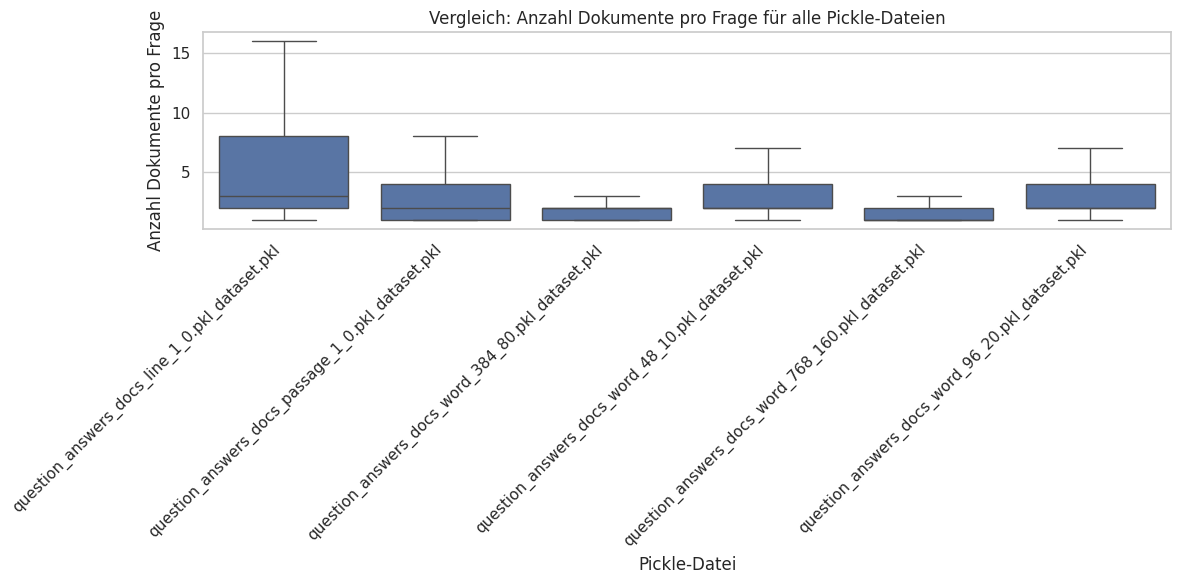

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dieser globale Container sammelt alle Counts aus jedem einzelnen Pickle
records = []

def validate_qa_with_docs(filename, df):
    # Länge der Liste df["documents"] pro Frage
    doc_counts = df["documents"].apply(len)
    # für jede Count ein Record mit Dateiname
    for cnt in doc_counts:
        records.append({
            "file": filename,
            "doc_count": cnt
        })

# hier wird wie gewohnt über alle Pickles iteriert,
# our callback füllt nur 'records'
for_each_pickle_file("data/qa_with_docs", validate_qa_with_docs)

# nach der Schleife haben wir alles in records – jetzt einmaliges Boxplot
plot_df = pd.DataFrame(records)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=plot_df,
    x="file",
    y="doc_count",
    showfliers=False        # Ausreißer ausblenden, optional
)
plt.title("Vergleich: Anzahl Dokumente pro Frage für alle Pickle-Dateien")
plt.xlabel("Pickle-Datei")
plt.ylabel("Anzahl Dokumente pro Frage")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Check Reference to Document Mapping

Checks if the documents mapped to the question contain all the references from that question.

In [4]:
import pandas as pd

def find_missing_reference_matches_in_df(filename, df):
    # Show all columns, rows, and avoid truncating column content
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)

    def find_missing_refs(references, documents):
        missing_refs = []

        for ref in references:
            if len(find_matching_docs([ref], documents, threshold=0.5)) == 0:
                missing_refs.append(ref)

        return missing_refs

    # Apply function to extract missing references
    df["missing_refs"] = df.apply(
        lambda row: find_missing_refs(row["references"], row["documents"]), axis=1
    )

    # Only keep rows with missing references
    failed_rows = df[df["missing_refs"].apply(len) > 0]

    print(f"f{filename}: {len(failed_rows)} rows have missing reference matches.")
    print(failed_rows[["question", "references", "missing_refs", "documents"]])

for_each_pickle_file("data/qa_with_docs", find_missing_reference_matches_in_df)

Processing Pickle files:  17%|█▋        | 1/6 [01:10<05:53, 70.70s/it]

fquestion_answers_docs_line_1_0.pkl_dataset.pkl: 0 rows have missing reference matches.
Empty DataFrame
Columns: [question, references, missing_refs, documents]
Index: []


Processing Pickle files:  33%|███▎      | 2/6 [02:19<04:38, 69.61s/it]

fquestion_answers_docs_passage_1_0.pkl_dataset.pkl: 0 rows have missing reference matches.
Empty DataFrame
Columns: [question, references, missing_refs, documents]
Index: []


Processing Pickle files:  50%|█████     | 3/6 [03:29<03:28, 69.66s/it]

fquestion_answers_docs_word_384_80.pkl_dataset.pkl: 0 rows have missing reference matches.
Empty DataFrame
Columns: [question, references, missing_refs, documents]
Index: []


Processing Pickle files:  67%|██████▋   | 4/6 [04:38<02:18, 69.43s/it]

fquestion_answers_docs_word_48_10.pkl_dataset.pkl: 0 rows have missing reference matches.
Empty DataFrame
Columns: [question, references, missing_refs, documents]
Index: []


Processing Pickle files:  83%|████████▎ | 5/6 [05:49<01:09, 69.92s/it]

fquestion_answers_docs_word_768_160.pkl_dataset.pkl: 0 rows have missing reference matches.
Empty DataFrame
Columns: [question, references, missing_refs, documents]
Index: []


Processing Pickle files: 100%|██████████| 6/6 [07:01<00:00, 70.17s/it]

fquestion_answers_docs_word_96_20.pkl_dataset.pkl: 0 rows have missing reference matches.
Empty DataFrame
Columns: [question, references, missing_refs, documents]
Index: []


## Flatten Question Variations

In [5]:
df = pd.read_pickle("data/question_answers_with_documents.pkl")

In [9]:
import json
import pandas as pd
from tqdm import tqdm
import os

def flatten(filename, df):
    new_rows = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Flattening Question Variations"):
        # 0) Include the original row itself
        orig = row.copy()
        orig["variant"]       = "default"
        orig["prev_messages"] = []
        new_rows.append(orig)

        # 1) Unpack each variation
        variations = json.loads(row["variations"])
        for variation_key, variation_val in variations.items():
            nr = row.copy()
            nr["variant"] = variation_key

            if variation_key == "contextual" and isinstance(variation_val, list):
                nr["question"]      = variation_val[-1]["message"]
                nr["prev_messages"] = [m["message"] for m in variation_val[:-1]]
            else:
                nr["question"]      = variation_val
                nr["prev_messages"] = []

            new_rows.append(nr)

    # 2) Build your flattened DataFrame and drop 'variations'
    flat_df = (
        pd.DataFrame(new_rows)
        .reset_index(drop=True)
        .drop(columns=["variations"])
    )
    # Strip .pkl if it exists
    clean_name = os.path.splitext(os.path.basename(filename))[0]
    flat_df.to_pickle(f"data/qa_with_docs_flat/{clean_name}_flat.pkl")

for_each_pickle_file("data/qa_with_docs", flatten)

Processing Pickle files: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]
